# Quantitative Model Training Notebook
This Notebook is designed to determine the empirical parameters needed to estimate concentration ratios from Raman intensity ratios. It requires given pre-processed input spectra generated by the OSTRI_Raman-Processing Notebook, which must be carefully baselined to ensure generation of an accurate model. The model uses bootstrapping to estimate fitting and prediction errors, which requires 10+ spectra per sample.

In [1]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './output/'
Fig_dir = './new figures/'
Out_dir = './output/'
Ref_dir = './data/Standards/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# filter data import by sample / subsample
Instrument = 'Fornaro'           # name of Instrument
Mixture = '9MA_CaSO4'     # name of mixture series, please only run one at a time
File = 'all-spectra-baselined'

# list of filenames not to import
Do_Not_Import = []

Components = Mixture.split("_")

# specify which components to use as A and B
Evaluation_Components = [Components[0], Components[-1]]

# specify which intensity values to use for each component
Intensity_Keys = {
    'dATP': {'Raw': [1310, 1460], 'Fitting': [1310]},
    'dCTP': {'Raw': [1505, 1625], 'Fitting': [1510]},
    'dGTP': {'Raw': [1460, 1560], 'Fitting': [1460]},
    'dTTP': {'Raw': [1350, 1635], 'Fitting': [1635]},
    'Na2SO4': {'Raw': [945], 'Fitting': [945]},
    'H2O': {'Raw': [3400], 'Fitting': [3400]},
    '9MA': {'Raw': [1600], 'Fitting': [1600, 1550, 1660]},
    '13DHN': {'Raw': [1600], 'Fitting': [1600]},
    'IOM': {'Raw': [1600], 'Fitting': [1600]},
    'CaSO4': {'Raw': [1004], 'Fitting': [1004]}
}

# Define method for evaluating intensities
Intensity_Method = 'Raw'        # method for measuring intensity, 'Raw', 'Fitting', or 'Deconvolution'
Fitting_property = 'amplitude'  # fitted peak property to use as intensity, 'amplitude' or 'area'

# Specify whether to bootstrap resample data (needed to estimate errors, requires 10+ spectra per sample)
Bootstrap = True
N_Bootstraps = 1000

Laser_Wavelength = '248'        # wavelength in nm, as str

Seed = 1001

In [2]:
# ==================================================
# this section imports necessary python modules and looks for available data files

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from itertools import combinations
from itertools import combinations_with_replacement

# import VibSpec module functions
from OSTRI_functions import *

"""
# ==================================================
# FILE SEARCH
# - this section searches for spectrum files that match the specified settings
# ==================================================
"""

print("SEARCHING FOR SPECTRUM DATA FILES...")

# find files
#   - currently requires data files to be named and organised as follows:
# Data_dir/{Sample}/{Measurement_Date}/{Measurement_ID}_{Sample}_{Subsample}_{Measurement Parameters}.txt
text = "%s%s/%s_*/*_%s.csv" % (Data_dir, Mixture, Instrument, File)
print(text)
spec_dirs = sorted(glob.glob(text))

# for each file, get components and concentrations for sorting
mixtures = []
conc_ratios = []
for file in spec_dirs:
    while True:
        try:
            temp = file.split("/")[-1][:-4].split("_")[0:-1]
            components = {}
            for item in temp:
                if len(item.split("-")) == 2:
                    comp, val = item.split("-")
                    for i, c in enumerate(val):
                        if c not in '0123456789.':
                            conc = float(val[:i])
                            unit = val[i:]
                            break
                    # standardise units to ppm
                    if unit == 'wt':
                        conc_ppm = conc * 1000000. / 100.
                    elif unit == 'mM':
                        conc_ppm = conc * 1000000. / 55510.
                    components[comp] = conc_ppm
            conc_ratio = np.float64(components[Components[0]]) / np.float64(components[Components[1]])
            mixtures.append("_".join(list(components.keys())))
            conc_ratios.append(conc_ratio)
            break
        except Exception as e:
            print("something went wrong! Exception:", e)
            break
            
# sort by mixture and concentration ratio
sort = np.lexsort((conc_ratios, mixtures))
spec_dirs = np.asarray(spec_dirs)[sort]

print("data files found:", len(spec_dirs))
for file in spec_dirs:
    print("    ", file.split("/")[-1])
    comps = file.split("/")[-1][:-4].split("_")[0:-1]
    for comp in comps:
        if len(comp.split("-")) == 2:
            comp, conc = comp.split("-")
            print("        %10s: %10s" % (comp, conc))

SEARCHING FOR SPECTRUM DATA FILES...
./output/9MA_CaSO4/Fornaro_*/*_all-spectra-baselined.csv
data files found: 11
     9MA-0.00001wt_CaSO4-100wt_all-spectra-baselined.csv
               9MA:  0.00001wt
             CaSO4:      100wt
     9MA-0.0001wt_CaSO4-100wt_all-spectra-baselined.csv
               9MA:   0.0001wt
             CaSO4:      100wt
     9MA-0.0005wt_CaSO4-100wt_ALL_all-spectra-baselined.csv
               9MA:   0.0005wt
             CaSO4:      100wt
     9MA-0.001wt_CaSO4-100wt_all-spectra-baselined.csv
               9MA:    0.001wt
             CaSO4:      100wt
     9MA-0.005wt_CaSO4-100wt_ALL_all-spectra-baselined.csv
               9MA:    0.005wt
             CaSO4:      100wt
     9MA-0.01wt_CaSO4-100wt_all-spectra-baselined.csv
               9MA:     0.01wt
             CaSO4:      100wt
     9MA-0.05wt_CaSO4-100wt_ALL_all-spectra-baselined.csv
               9MA:     0.05wt
             CaSO4:      100wt
     9MA-0.1wt_CaSO4-99.9wt_ALL_all-spectra-baseline

# Data import

- this section actually imports data files and their corresponding metadata
- metadata can be in a separate CSV file with the same name plus '\_metadata', or can be extracted from the data file's name
- measurements are imported file by file, and added sequentially to the 'data' dict
- to access a specific measurement, you call data\[measurement ID\]\[key\], where 'key' is the type of data you want from it

In [3]:
print("IMPORTING DATA...")

# print debug messages?
debug = True

# set up data storage dictionary
spec_data = {}
int_data = {}

# ==================================================
# each measurement imported will be added to this dictionary as a Measurement object
# To access a particular measurement, use data[measurement ID]

# for each detected file
count = 0
for spec_dir in spec_dirs:
    while True:
        try:
            filename = spec_dir.split("/")[-1][:-4]
            title = file.split("/")[-2]
            ID = count
            if filename in Do_Not_Import:
                print()
                print(" measurement %s is in Do_Not_Import list, skipping" % filename)
                break
            else:
                print()
                print("importing %s" % filename)
                print(title)
                # extract sample/measurement metadata
                instrument = filename.split("_")[0]
                temp = filename.split("_")[:-1]
                components = {}
                for item in temp:
                    if len(item.split("-")) == 2:
                        comp, val = item.split("-")
                        for i, c in enumerate(val):
                            if c not in '0123456789.':
                                conc = float(val[:i])
                                unit = val[i:]
                                break
                        # standardise units to ppm
                        if unit == 'wt':
                            conc_ppm = conc * 1000000. / 100.
                        elif unit == 'mM':
                            conc_ppm = conc * 1000000. / 55510.
                        components[comp] = conc_ppm
                        print("        %10s: %0.1E %s - %0.1E ppm" % (comp, conc, unit, conc_ppm))
                conc_ratio = components[Evaluation_Components[0]]/components[Evaluation_Components[1]]
                print("evaluated conc. ratio: %0.1E %s/%s" % (conc_ratio, Evaluation_Components[0], Evaluation_Components[1]))
                # import spectrum file (assumes pre-processed OSTRI data file format)
                spec = np.genfromtxt(spec_dir, delimiter=',', skip_header=1).transpose()
                print("    spec array:", np.shape(spec))
                xy_coords = np.asarray([[0],[0]])
                points = np.size(spec, axis=0) - 2
                if points > 1:
                    spec_type = 'map'
                    print("    spectral map, %s points" % (points))
                else:
                    spec_type = 'point'
                    print("    single point measurement")
                wavelength = spec[0]
                raman_shift = spec[1]
                y = spec[2:]
                sort = np.argsort(raman_shift)
                raman_shift = raman_shift[sort]
                y = y.transpose()[sort,:]
                        
                infcheck = np.any(np.isinf(y), axis=1)
                nancheck = np.any(np.isnan(y), axis=1)
                zerocheck = np.any(y == 0, axis=1)
                check = np.logical_or.reduce((infcheck, nancheck, zerocheck))
                if debug == True:
                    print("              shift:", np.shape(raman_shift))
                    print("          intensity:", np.shape(y))
                    print("        shift range: %0.f - %0.f cm-1" % (np.nanmin(raman_shift), np.nanmax(raman_shift)))
                    print("         inf check: %0.f/%0.f" % (np.count_nonzero(infcheck),
                                                               np.size(infcheck)))
                    print("         nan check: %0.f/%0.f" % (np.count_nonzero(nancheck),
                                                               np.size(nancheck)))
                    print("        zero check: %0.f/%0.f" % (np.count_nonzero(zerocheck),
                                                               np.size(zerocheck)))
                if np.count_nonzero(check) > 0.1 * np.size(check):
                    raise Exception("%0.f%% of spectrum data is 0/nan/inf! Cannot import!" % (100*np.count_nonzero(check)/np.size(check)))
                # get average spectrum (for single points, just use spec)
                y_av = np.mean(y, axis=0)
                # define name for output folder structure
                output_folder = '%s/%s/' % ("_".join(components.keys()), title)
                # create Measurement instance from imported data
                spec_data[str(ID)] = Measurement(
                    ID=str(ID),
                    title=title,
                    filename=filename,
                    sample="/".join(Mixture.split("_")),
                    components=components,
                    conc_ratio=conc_ratio,
                    x=raman_shift[~check],
                    y=y[~check],
                    spec_type=spec_type,
                    points=points,
                    ykey='y',
                    technique='Raman',
                    instrument=instrument,
                    laser_wavelength=Laser_Wavelength,
                    generate_average=True,
                    x_coords=xy_coords[0],
                    y_coords=xy_coords[1],
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    output_folder = output_folder
                )
                
                count += 1
                print("    imported successfully!")
                break
        except Exception as e:
            print("    something went wrong! Exception:", e)
            break
        
print()
print("%s/%s files imported" % (len(spec_data.keys()), len(spec_dirs)))

# ==================================================
# update list of Spec IDs to only include imported spectra

Spec_IDs = list(spec_data.keys())

# ==================================================
# report how many distinct laser wavelengths are represented in dataset

lasers = np.unique([measurement.laser_wavelength for ID, measurement in spec_data.items()])
print()
print("laser wavelengths in dataset:")
for laser in lasers:
    print("    ", laser, "nm")

# ==================================================
# handle concentrations and ratios

int_data = {
    'components': Components
}

for comp in Components:
    int_data['C_%s' % comp] = np.asarray([spec_data[ID]['components'][comp] for ID in Spec_IDs])
    print()
    print('C_%s' % comp, np.shape(int_data['C_%s' % comp]))
    print("    ", np.array2string(int_data['C_%s' % comp], formatter={'float_kind':lambda x: "%0.1E" % x}))
    
comp_pairs = combinations(Components, 2)

for pair in comp_pairs:
    A, B = pair
    int_data['CR_%s/%s' % (A, B)] = int_data['C_%s' % A] / int_data['C_%s' % B]
    print()
    print('CR_%s/%s' % (A, B), np.shape(int_data['CR_%s/%s' % (A, B)]))
    print("    ", np.array2string(int_data['CR_%s/%s' % (A, B)], formatter={'float_kind':lambda x: "%0.1E" % x}))

IMPORTING DATA...

importing 9MA-0.00001wt_CaSO4-100wt_all-spectra-baselined
Fornaro_9MA-1wt_CaSO4-99wt
               9MA: 1.0E-05 wt - 1.0E-01 ppm
             CaSO4: 1.0E+02 wt - 1.0E+06 ppm
evaluated conc. ratio: 1.0E-07 9MA/CaSO4
    spec array: (3, 1024)
    single point measurement
              shift: (1024,)
          intensity: (1024, 1)
        shift range: 338 - 3688 cm-1
         inf check: 0/1024
         nan check: 0/1024
        zero check: 0/1024
    imported successfully!

importing 9MA-0.0001wt_CaSO4-100wt_all-spectra-baselined
Fornaro_9MA-1wt_CaSO4-99wt
               9MA: 1.0E-04 wt - 1.0E+00 ppm
             CaSO4: 1.0E+02 wt - 1.0E+06 ppm
evaluated conc. ratio: 1.0E-06 9MA/CaSO4
    spec array: (3, 1024)
    single point measurement
              shift: (1024,)
          intensity: (1024, 1)
        shift range: 338 - 3688 cm-1
         inf check: 0/1024
         nan check: 0/1024
        zero check: 0/1024
    imported successfully!

importing 9MA-0.0005wt_CaSO4

## Plot Imported Spectra

PLOTTING PROCESSED SPECTRA...
[1.00000000e-07 1.00000000e-06 5.00000000e-06 1.00000000e-05
 5.00000000e-05 1.00000000e-04 5.00000000e-04 1.00100100e-03
 6.41083703e-03 9.98990918e-03 1.01010101e-02]


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1270698005.py:117: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1270698005.py:182: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


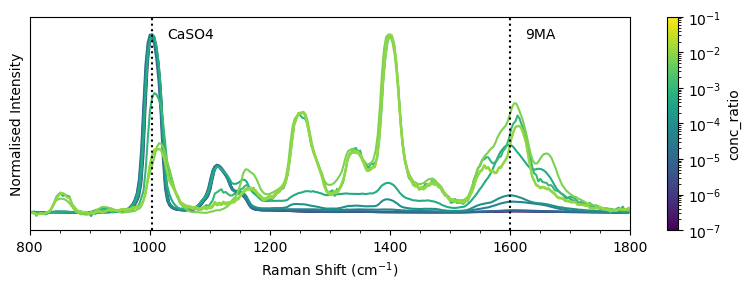

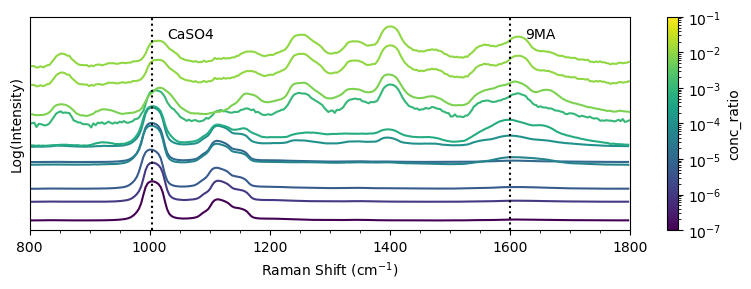

In [4]:
#
skip = False

# print debug messages in viewer?
debug = True

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y'

# X range for plotting spectra
x_start, x_end = (800, 1800)

# property to use for colour mapping
colour_by = 'conc_ratio'
colour_norm = 'log'

# offset spectra
offset = 0.

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("skipping this section...")
else:
    print("PLOTTING PROCESSED SPECTRA...")
    
    peaks = np.concatenate([Intensity_Keys[comp]['Raw'] for comp in Components])
    peak_labels = np.concatenate([[comp]*len(Intensity_Keys[comp]['Raw']) for comp in Components])
    sort = np.argsort(peaks)
    peaks = peaks[sort]
    peak_labels = peak_labels[sort]
    
    if 'H2O' in Components:
        hydration = True
        fig, axs = plt.subplots(1, 2, figsize=(10,3), gridspec_kw={'width_ratios': [2, 1]})
        ax1, ax2 = axs
        ax2.set_xlim(2600, 3800)
        ax2.set_yticks([])
        ax2.minorticks_on()
    else:
        hydration = False
        fig, ax1 = plt.subplots(1, 1, figsize=(8,3))
    ax1.set_xlim(x_start, x_end)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([])
    ax1.set_xlabel("Raman Shift (cm$^{-1}$)")
    ax1.set_ylabel("Normalised Intensity")
    ax1.minorticks_on()
    
    # generate colour map
    cmap_yesno = False
    if colour_by in ['conc_ratio']:
        # generate colour map based on sample/measurement property
        temp = np.asarray([getattr(spec_data[ID], colour_by, np.nan) for ID in Spec_IDs])
        print(temp)
        if colour_norm == 'log':
            check = np.logical_and(temp <= 0, np.isnan(temp))
            temp[check] = np.nan
            norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(np.nanmin(temp))),
                                          vmax=10**np.ceil(np.log10(np.nanmax(temp))))
        else:
            norm = mpl.colors.Normalize(vmin=np.nanmin(temp), vmax=np.nanmax(temp))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
        cmap.set_array([])
        plot_colours = cmap.to_rgba(temp)
        if hydration == True:
            plt.colorbar(cmap, ax=ax2, label=colour_by)
        else:
            plt.colorbar(cmap, ax=ax1, label=colour_by)
    elif len(Spec_IDs) < 10:
        # give each spectrum its own colour
        plot_colours = [Colour_List[i % len(Colour_List)] for i in range(len(Spec_IDs))]
    else:
        # too many spectra to plot, use group colour for all
        plot_colours = np.full(len(Spec_IDs), Colour_List[0])
        
    # add spectra to figure
    for i, ID in enumerate(Spec_IDs):
        # plot main region in ax1
        x, y = get_plot_data(spec_data[ID], x_key, y_key+"_av", start=ax1.get_xlim()[0], end=ax1.get_xlim()[1],
                    normalise=False, debug=False)
        y_max = np.nanmax(y)
        ax1.plot(x, y/y_max, c=plot_colours[i])
        if hydration == True:
            x, y = get_plot_data(spec_data[ID], x_key, y_key+"_av", start=ax2.get_xlim()[0], end=ax2.get_xlim()[1],
                    normalise=False, debug=False)
            ax2.plot(x, y/y_max, c=plot_colours[i])
        
    # plot evaluated peak positions
    for peak, label in zip(peaks, peak_labels):
        if ax1.get_xlim()[0] < peak and peak < ax1.get_xlim()[1]:
            ax1.axvline(peak, color='k', linestyle=':')
            ax1.text(peak+25, ax1.get_ylim()[1]-0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0]), label)
        if hydration == True:
            if ax2.get_xlim()[0] < peak and peak < ax2.get_xlim()[1]:
                ax2.axvline(peak, color='k', linestyle=':')
                ax2.text(peak+25, ax2.get_ylim()[1]-0.1*(ax2.get_ylim()[1]-ax2.get_ylim()[0]), label)
    
    # add hydration scale factor
    if hydration == True:
        factor = ax2.get_ylim()[1] / ax1.get_ylim()[1]
        ax2.text(0.05, 0.95, "%0.fx" % factor, ha='left', va='top', transform=ax2.transAxes)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0)
    if save_plot == True:
        fig.savefig("%s%s/%s_spectra.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        fig.savefig("%s%s/%s_spectra.svg" % (Fig_dir, Mixture, Mixture), dpi=300)
    if show_plot == True:
        fig.show()
    else:
        fig.close()
        
    # now plot with offset
    count = 1
    log_offset = 0.5
    
    if 'H2O' in Components:
        hydration = True
        fig, axs = plt.subplots(1, 2, figsize=(10,3), gridspec_kw={'width_ratios': [2, 1]})
        ax1, ax2 = axs
        ax2.set_xlim(2600, 3800)
        ax2.set_yticks([])
        ax2.minorticks_on()
    else:
        hydration = False
        fig, ax1 = plt.subplots(1, 1, figsize=(8,3))
    ax1.set_xlim(x_start, x_end)
    ax1.set_yticks([])
    ax1.set_xlabel("Raman Shift (cm$^{-1}$)")
    ax1.set_ylabel("Log(Intensity)")
    ax1.minorticks_on()
    
    if colour_by in ['conc_ratio']:
        if hydration == True:
            plt.colorbar(cmap, ax=ax2, label=colour_by)
        else:
            plt.colorbar(cmap, ax=ax1, label=colour_by)
            
    # add spectra to figure
    for i, ID in enumerate(Spec_IDs):
        # plot main region in ax1
        x, y = get_plot_data(spec_data[ID], x_key, y_key+"_av", start=ax1.get_xlim()[0], end=ax1.get_xlim()[1],
                    normalise=False, debug=False)
        y = y[:,-1]
        y_max = np.nanmax(y)
        ax1.plot(x, np.log10(y + 0.1*y_max)+count*log_offset, c=plot_colours[i])
        if hydration == True:
            x, y = get_plot_data(spec_data[ID], x_key, y_key+"_av", start=ax2.get_xlim()[0], end=ax2.get_xlim()[1],
                    normalise=False, debug=False)
            y = y[:,-1]
            ax2.plot(x, np.log10(y + 0.1*y_max)+count*log_offset, c=plot_colours[i])
        count += 1
        
    # plot evaluated peak positions
    for peak, label in zip(peaks, peak_labels):
        if ax1.get_xlim()[0] < peak and peak < ax1.get_xlim()[1]:
            ax1.axvline(peak, color='k', linestyle=':')
            ax1.text(peak+25, ax1.get_ylim()[1]-0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0]), label)
        if hydration == True:
            if ax2.get_xlim()[0] < peak and peak < ax2.get_xlim()[1]:
                ax2.axvline(peak, color='k', linestyle=':')
                ax2.text(peak+25, ax2.get_ylim()[1]-0.1*(ax2.get_ylim()[1]-ax2.get_ylim()[0]), label)
        
    # add hydration scale factor
    if hydration == True:
        factor = ax2.get_ylim()[1] / ax1.get_ylim()[1]
        ax2.text(0.05, 0.95, "%0.fx" % factor, ha='left', va='top', transform=ax2.transAxes)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    if save_plot == True:
        fig.savefig("%s%s/%s_spectra-log.png" % (Fig_dir, Mixture, Mixture), dpi=300)
    if show_plot == True:
        fig.show()
    else:
        fig.close()

# Get Intensity Values
Uses method specified by Intensity_Method at the start of the NoteBook. Currently only Raw Mode is functional.

Raw Mode: Returns absolute intensity (in counts) at a specified peak position. Requires the following:
    - positions dict containing component:[peak position] pairs, 1+ positions per component

MEASURING RAW INTENSITIES...

samples in dataset: 11
measurements per sample: [1, 1, 919, 1, 821, 1, 775, 9, 528, 16, 1]
    max: 919

peaks to process:
       9MA: 1600 cm-1 (11, 919)
     CaSO4: 1004 cm-1 (11, 919)


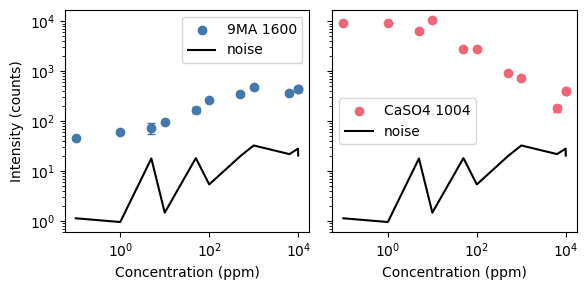


IR_1600/1004 (11, 919)

end of Raw Mode measurement section!


In [5]:
# print debug messages in viewer?
debug = True

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y'

# smooth data before measuring intensity?
smooth = True

show_plot = True

save_plot = True

show_noise = True

if Intensity_Method != 'Raw':
    print("skipping this section...")
else:
    print("MEASURING RAW INTENSITIES...")
    
    # determine largest measurement array size
    lengths = [spec_data[ID].points for ID in Spec_IDs]
    print()
    print("samples in dataset:", len(Spec_IDs))
    print("measurements per sample:", lengths)
    print("    max:", max(lengths))
    
    # ==================================================
    # pick peak positions based on components
    
    int_data['peaks'] = np.concatenate([Intensity_Keys[comp]['Raw'] for comp in int_data['components']])
    int_data['peak_labels'] = np.concatenate([[comp]*len(Intensity_Keys[comp]['Raw']) for comp in int_data['components']])
    print()
    print("peaks to process:")
    for peak, label in zip(int_data['peaks'], int_data['peak_labels']):
        int_data["I_%d" % peak] = np.full((len(Spec_IDs), max(lengths)), np.nan, dtype=np.float64)
        print("%10s: %4d cm-1" % (label, peak), np.shape(int_data["I_%d" % peak]))
        
    for i1, ID in enumerate(Spec_IDs):
        # for each measurement
        
        # get spectrum
        x, y = spec_data[ID](x_key, y_key)
        
        if smooth == True:
            for i in range(np.size(y, axis=1)):
                y[:,i] = smooth_spectrum(y[:,i], 5, 3)
        
        for peak in int_data['peaks']:
            # get intensity for this peak
            y_vals = y[np.argmin(np.abs(x - peak)),:]
            
            # remove non-positives and outliers
            check = np.logical_or(y_vals <= 0, np.isinf(y_vals))
            y_vals[check] = np.nan
            
            length = spec_data[ID].points
            
            int_data["I_%d" % peak][i1,:length] = y_vals

    if show_plot == True or save_plot == True:
        x_label = Mixture.split("_")[0]
        fig, axs = plt.subplots(1, len(int_data['peak_labels']), figsize=(3*len(int_data['peak_labels']), 3),
                                sharex=True, sharey=True, subplot_kw={'xscale': 'log', 'yscale': 'log'})
        for ax, peak, label in zip(axs.flat, int_data['peaks'], int_data['peak_labels']):
            ax.set_xlabel("Concentration (ppm)")
            if ax == axs.flat[0]:
                ax.set_ylabel("Intensity (counts)")
            x_vals = [spec_data[ID].components[x_label] for ID in Spec_IDs]
            y_vals = int_data["I_%d" % peak]
            colour = Colour_List[list(spec_data[ID].components.keys()).index(label)]
            ax.errorbar(x_vals, np.nanmean(y_vals, axis=1), yerr=np.nanstd(y_vals, axis=1), fmt='none', c=colour, capsize=3)
            ax.scatter(x_vals, np.nanmean(y_vals, axis=1), c=colour, label='%s %d' % (label, peak))
            if show_noise == True:
                y_temp = np.zeros_like(np.nanmean(y_vals, axis=1))
                for i, ID in enumerate(Spec_IDs):
                    x, y = spec_data[ID](x_key, y_key)
                    slicer = np.ravel(np.where((1900 <= x) & (x <= 2000)))
                    y_temp[i] = np.nanmean(np.nanstd(y[slicer,:], axis=0))
                ax.plot(x_vals, y_temp, 'k', label='noise', zorder=0)
            ax.legend()
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s%s_raw-intensities.png" % (Fig_dir, Mixture, Mixture), dpi=300)
            plt.savefig("%s%s%s_raw-intensities.svg" % (Fig_dir, Mixture, Mixture), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()
    
    # ==================================================
    # calculate intensity ratios
    
    comp_pairs = combinations(int_data['peaks'], 2)
    
    for pair in comp_pairs:
        A, B = pair
        int_data['IR_%s/%s' % (A, B)] = int_data['I_%s' % A] / int_data['I_%s' % B]
        print()
        print('IR_%s/%s' % (A, B), np.shape(int_data['IR_%s/%s' % (A, B)]))
    
    print()
    print("end of Raw Mode measurement section!")

## Plot Measured Intensity Ratio Curves

PLOTTING INTENSITY CURVES...
v1 peaks ( ['9MA']): [1600]


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1604540991.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


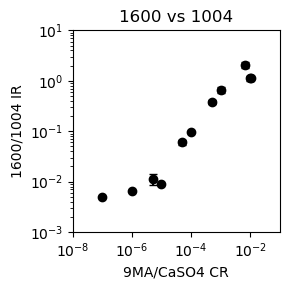

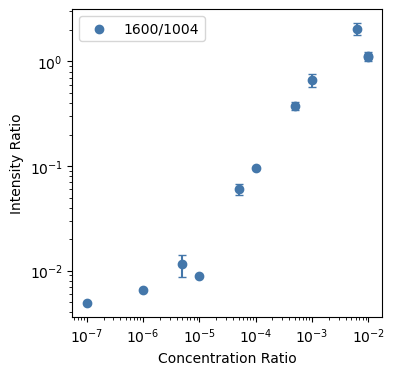

In [6]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = True

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("skipping this section...")
else:
    print("PLOTTING INTENSITY CURVES...")
    
    temp = [Evaluation_Components[0]]
    v1_peaks = np.concatenate([int_data['peaks'][int_data['peak_labels'] == comp] for comp in temp])
    v1_comps = np.concatenate([int_data['peak_labels'][int_data['peaks'] == peak] for peak in v1_peaks])
    print("v1 peaks (%8s):" % v1_comps, v1_peaks)
    temp = [comp for comp in Components if comp != Evaluation_Components[0]]
    v2_peaks = np.concatenate([int_data['peaks'][int_data['peak_labels'] == comp] for comp in temp])
    v2_comps = np.concatenate([int_data['peak_labels'][int_data['peaks'] == peak] for peak in v2_peaks])
    
    plot_count = len(v1_peaks) * len(v2_peaks)
    
    fig, axs = plt.subplots(1, plot_count, figsize=(3*plot_count,3), sharey=True)
    
    # get y axis limits
    y = []
    for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
        for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
            IR = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            y.append(np.nanmean(IR, axis=1))
    y = np.concatenate(y)
    check = np.logical_or(y <= 0, np.isinf(y))
    y[check] = np.nan
    y_min = 10**np.floor(np.log10(0.9*np.nanmin(y)))
    y_max = 10**np.ceil(np.log10(1.1*np.nanmax(y)))
    y_lim = (y_min, y_max)
    
    i = 0
    for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
        for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
            x = int_data['CR_%s/%s' % (v1_comp, v2_comp)]
            y = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            
            if plot_count == 1:
                ax = axs
            else:
                ax = axs[i]
            ax.set_title("%s vs %s" % (v1_peak, v2_peak))
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel("%s/%s CR" % (v1_comp, v2_comp))
            if i == 0:
                ax.set_ylabel("%s/%s IR" % (v1_peak, v2_peak))
            x_min = 10**np.floor(np.log10(0.9*np.nanmin(x)))
            x_max = 10**np.ceil(np.log10(1.1*np.nanmax(x)))
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
                    
            y_av = np.nanmean(y, axis=1)
            y_std = np.nanstd(y, axis=1)
                    
            ax.errorbar(x, y_av, yerr=y_std, c='k', fmt='none', capsize=3)
            ax.scatter(x, y_av, c='k')
                    
            i += 1
    
    fig.tight_layout()
    if save_plot == True:
        fig.savefig("%s%s/%s_intensities.png" % (Fig_dir, Mixture, Mixture), dpi=300)
    if show_plot == True:
        fig.show()
    else:
        fig.close()
    
    plt.figure(figsize=(4,4))
    i = 0
    for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
        for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
            x = int_data['CR_%s/%s' % (v1_comp, v2_comp)]
            y = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            
            y_av = np.nanmean(y, axis=1)
            y_std = np.nanstd(y, axis=1)
            
            plt.errorbar(x, y_av, yerr=y_std, c=Colour_List[i], fmt='none', capsize=3)
            plt.scatter(x, y_av, c=Colour_List[i], label='%s/%s' % (v1_peak, v2_peak))
                    
            i += 1
                    
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Concentration Ratio")
    plt.ylabel("Intensity Ratio")
    plt.show()

## Fit Data with Quantitative Model

FITTING QUANTITATIVE MODEL TO TRAINING DATA...
v1 peaks ( ['9MA']): [1600]

1600-vs-1004
    CR,IR arrays: (11,) (11, 919)

     bootstrapping input data, N = 1000
          input data array: (11, 919)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(11,) (11,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004915        0      inf     None     True     None     None
FXJ     965.1    1e-

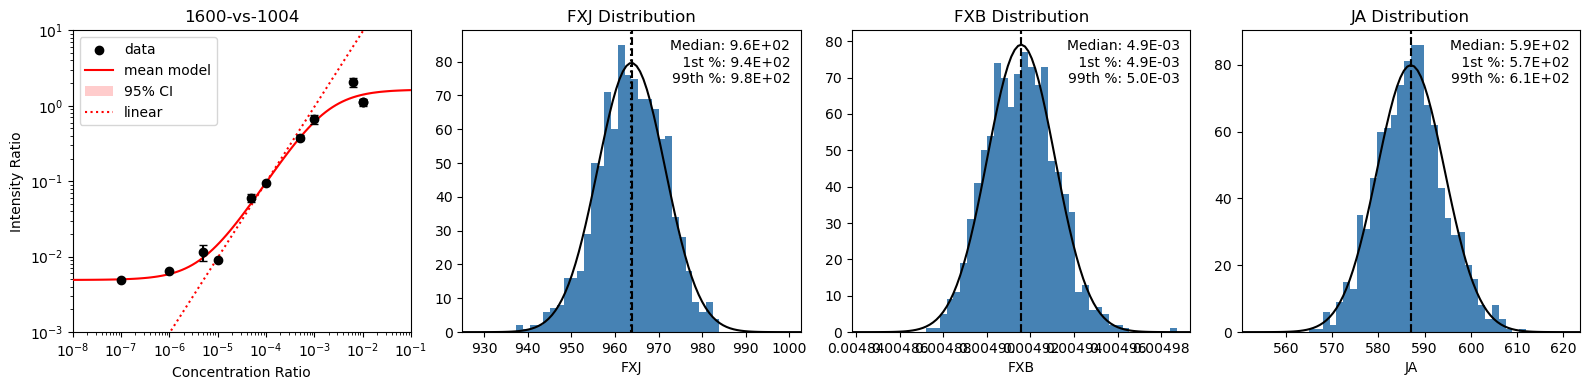


         end of plot_quantmodel_summary() function
           FXJ: (9.64, 9.56-9.72)x10^2
           FXB: (4.92, 4.90-4.93)x10^-3
            JA: (5.87, 5.80-5.94)x10^2
        FXJ_JA: (1.64, 1.62-1.66)x10^0

DONE


In [7]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = True

# plot covariances from bootstrapping?
plot_covariance = False

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

fits = {}
tables = {}

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL TRAINING...")
else:
    print("FITTING QUANTITATIVE MODEL TO TRAINING DATA...")
    
    # determine how many peak pair combinations to process
    temp = [Evaluation_Components[0]]
    v1_peaks = np.concatenate([int_data['peaks'][int_data['peak_labels'] == comp] for comp in temp])
    v1_comps = np.concatenate([int_data['peak_labels'][int_data['peaks'] == peak] for peak in v1_peaks])
    print("v1 peaks (%8s):" % v1_comps, v1_peaks)
    temp = [comp for comp in Components if comp != Evaluation_Components[0]]
    v2_peaks = np.concatenate([int_data['peaks'][int_data['peak_labels'] == comp] for comp in temp])
    v2_comps = np.concatenate([int_data['peak_labels'][int_data['peaks'] == peak] for peak in v2_peaks])
    
    for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
        for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
            d_key = "%s-vs-%s" % (v1_peak, v2_peak)
            title = "%s-vs-%s" % (v1_peak, v2_peak)
            fig_dir = "%s%s/" % (Fig_dir, Mixture)
            
            # get input data
            CR = int_data['CR_%s/%s' % (v1_comp, v2_comp)]
            IR = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            
            print()
            print(title)
            print("    CR,IR arrays:", np.shape(x), np.shape(y))
            
            # train the model
            if Bootstrap == True:
                fits[d_key] = bootstrap_intensity_fit_script(CR, IR, title=title, seed=626+int(v1_peak)+int(v2_peak),
                                                plot_linear=True, show_plot=show_plot, save_plot=save_plot,
                                                fig_dir=fig_dir, tabs=1, debug=debug)
            else:
                fits[d_key] = intensity_fit_script(CR, IR, debug=debug)
                        
            for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                text = percentiles2string(param=fits[title][key], percentiles=(16,84), include_median=True, n=2)
                print("        %6s: %s" % (key, text))
    
    print()
    print("DONE")

PLOTTING QUANTITATIVE MODELS...

1600-vs-1004


/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3902: RuntimeWarning: invalid value encountered in divide
  IR = (params["FXJ"] * CR + params["FXB"]) / (params["JA"] * CR + 1)


    LD (model): 3.9E-08 - 7.1E-02
    LD (noise): 4.9E-06 - 6.3E-02
    LQ (model): 7.3E-08 - 3.5E-02
    LQ (noise): 9.7E-06 - 3.2E-02


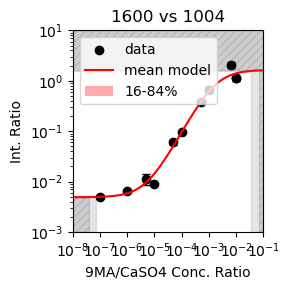


1600-vs-1004
       FXJ: (9.6, 9.6-9.7)E2
       FXB: (4.9, 4.9-4.9)E-3
        JA: (5.9, 5.8-5.9)E2
    FXJ_JA: (1.6, 1.6-1.7)E0


/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3902: RuntimeWarning: invalid value encountered in divide
  IR = (params["FXJ"] * CR + params["FXB"]) / (params["JA"] * CR + 1)
/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3107: RuntimeWarning: invalid value encountered in scalar divide
  curve = (IR - model["FXB"]) / (model["FXJ"] - model["JA"] * IR)
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [8]:
skip = False

show_plot = True
save_plot = True

"""
x_lims = (10**-7, 10**-3)
y_lims = (10**-3, 10**3)
"""

plot_detect_limits = True
plot_quant_limits = True

limit_type = 'model'

I1=500
I2=500
noise=1

threshold = 1

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL PLOTS...")
else:
    print("PLOTTING QUANTITATIVE MODELS...")
    
    plot_count = len(v1_peaks) * len(v2_peaks)
    
    fig, axs = plt.subplots(1, plot_count, figsize=(3*plot_count,3), sharey=True)
    
    # get collective y axis limits
    y = []
    for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
        for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
            title = "%s-vs-%s" % (v1_peak, v2_peak)
            fig_dir = "%s%s/" % (Fig_dir, Mixture)
            
            CR = int_data['CR_%s/%s' % (v1_comp, v2_comp)]
            IR = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            y.append(np.nanmean(IR, axis=1))
    y = np.concatenate(y)
    check = np.logical_or(y <= 0, np.isinf(y))
    y[check] = np.nan
    y_min = 10**np.floor(np.log10(0.9*np.nanmin(y)))
    y_max = 10**np.ceil(np.log10(1.1*np.nanmax(y)))
    y_lim = (y_min, y_max)
    
    # plot intensity ratio and fit for each combination of v1 and v2
    i = 0
    for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
        for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
            d_key = "%s-vs-%s" % (v1_peak, v2_peak)
            title = "%s-vs-%s" % (v1_peak, v2_peak)
            fig_dir = "%s%s/" % (Fig_dir, Mixture)
            print()
            print(title)
            
            # get fitted model
            model = fits[d_key]
            
            # get training data
            x = int_data['CR_%s/%s' % (v1_comp, v2_comp)]
            y = int_data['IR_%s/%s' % (v1_peak, v2_peak)]
            y_av = np.nanmean(y, axis=-1)
            y_std = np.nanstd(y, axis=-1)
            x_min = 10**np.floor(np.log10(0.9*np.nanmin(x)))
            x_max = 10**np.ceil(np.log10(1.1*np.nanmax(x)))
            x_lim = (x_min, x_max)
            
            if plot_count == 1:
                ax = axs
            else:
                ax = axs[i]
                
            ax.set_title("%s vs %s" % (v1_peak, v2_peak))
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel("%s/%s Conc. Ratio" % (v1_comp, v2_comp))
            if i == 0:
                ax.set_ylabel("Int. Ratio")
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            ax.set_xticks(np.logspace(np.log10(x_min), np.log10(x_max), int(np.log10(x_max)-np.log10(x_min)+1)))
            ax.minorticks_on()
                    
            # plot training data
            ax.errorbar(x, y_av, yerr=y_std, c='k', fmt='none', capsize=3)
            ax.scatter(x, y_av, c='k', label='data')
                    
            # plot mean model curve and confidence band
            x = np.logspace(np.log10(x_min), np.log10(x_max), 100)
            pred, lower, upper = predict_intensity(model, x, percentiles=(16,84), return_all=False)
            ax.plot(x, pred, 'r', label='mean model')
            ax.fill_between(x, lower, upper, color='r', linewidth=0., alpha=0.33, label='16-84%')
            
            # plot limits of detection
            if plot_detect_limits == True:
                # get detection limits
                LLD = get_detection_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                                 seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
                ULD = get_detection_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                                 seed=Seed, return_all=True, show_plot=False, tabs=1, debug=False)
                print("    LD (model): %0.1E - %0.1E" % (LLD['model'], ULD['model']))
                print("    LD (noise): %0.1E - %0.1E" % (LLD['noise'], ULD['noise']))
                
                if LLD[limit_type] > 0:
                    x = LLD[limit_type]
                    y = intensity_curve(model, LLD[limit_type])
                    ax.fill(
                        [x_min, x_min, x, x],
                        [y_min, y, y, y_min],
                        facecolor='k', edgecolor='k', alpha=0.1, hatch='////'
                    )
                if ULD[limit_type] < np.inf:
                    x = ULD[limit_type]
                    y = intensity_curve(model, ULD[limit_type])
                    ax.fill(
                        [x_min, x_min, x_max, x_max, x, x],
                        [y, y_max, y_max, y_min, y_min, y],
                        facecolor='k', edgecolor='k', alpha=0.1, hatch='////'
                    )
                    
            # plot limits of quantification
            if plot_quant_limits == True:
                # get quantification limits
                LLQ = get_quantification_limit(model, limit='lower', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                                      seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
                ULQ = get_quantification_limit(model, limit='upper', I1=I1, I2=I2, noise=noise, threshold=threshold,
                                                      seed=2*Seed, return_all=True, show_plot=False, tabs=1, debug=False)
                print("    LQ (model): %0.1E - %0.1E" % (LLQ['model'], ULQ['model']))
                print("    LQ (noise): %0.1E - %0.1E" % (LLQ['noise'], ULQ['noise']))
                
                if LLQ[limit_type] > 0:
                    x = LLQ[limit_type]
                    y = intensity_curve(model, LLQ[limit_type])
                    ax.fill(
                        [x_min, x_min, x, x],
                        [y_min, y, y, y_min],
                        facecolor='k', edgecolor='k', alpha=0.1
                    )
                if ULD[limit_type] < np.inf:
                    x = ULQ[limit_type]
                    y = intensity_curve(model, ULQ[limit_type])
                    ax.fill(
                        [x_min, x_min, x_max, x_max, x, x],
                        [y, y_max, y_max, y_min, y_min, y],
                        facecolor='k', edgecolor='k', alpha=0.1
                    )
                    
            if i == 0:
                ax.legend()
                    
            i += 1
    
    fig.tight_layout()
    if save_plot == True:
        fig.savefig("%s%s/%s_models.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        fig.savefig("%s%s/%s_models.svg" % (Fig_dir, Mixture, Mixture), dpi=300)
    if show_plot == True:
        plt.show()
    else:
        plt.close()
    
    # save results to table
    tables['models'] = pd.DataFrame(columns=['FXJ', 'FXB', 'JA', 'FXJ_JA', 'LLD', 'ULD','LLQ', 'ULQ'])
    for v2_peak, v2_comp in zip(v2_peaks, v2_comps):
        for v1_peak, v1_comp in zip(v1_peaks, v1_comps):
            d_key = "%s-vs-%s" % (v1_peak, v2_peak)
            title = "%s-vs-%s" % (v1_peak, v2_peak)
            print()
            print(title)
            
            # add parameters to table
            for prop in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                text = percentiles2string(param=fits[title][prop], percentiles=(16,84), n=1, e=True, include_median=True)
                print("    %6s: %s" % (prop, text))
                tables['models'].loc[title, prop] = text
                        
            # add limits to table
            for limit in ['lower', 'upper']:
                LD = get_detection_limit(fits[d_key], limit=limit, threshold=threshold,
                                         seed=626, return_all=True, show_plot=False, tabs=1, debug=False)
                LQ = get_quantification_limit(fits[d_key], limit=limit, threshold=threshold,
                                         seed=626, return_all=True, show_plot=False, tabs=1, debug=False)
            
                text = parameter2string(LD[limit_type], e=True, n=1)
                tables['models'].loc[title, "%sLD" % (limit.title()[0])] = text
                
                text = parameter2string(LQ[limit_type], e=True, n=1)
                tables['models'].loc[title, "%sLQ" % (limit.title()[0])] = text
                
                
    
    # save table to file
    tables['models'].T.to_csv("%s%s/model_results.csv" % (Out_dir, Mixture))

## Leave-One-Out Cross-Validation

FITTING QUANTITATIVE MODEL TO TRAINING DATA...

doing leave-one-out cross-validation...

comparing 1600/1004 (9MA/CaSO4)

CR,IR arrays: (11,) (11, 919)

cross-validation steps: 11


1/11
training model on data minus point 0 (CR = 1.0E-07)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)

     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated success

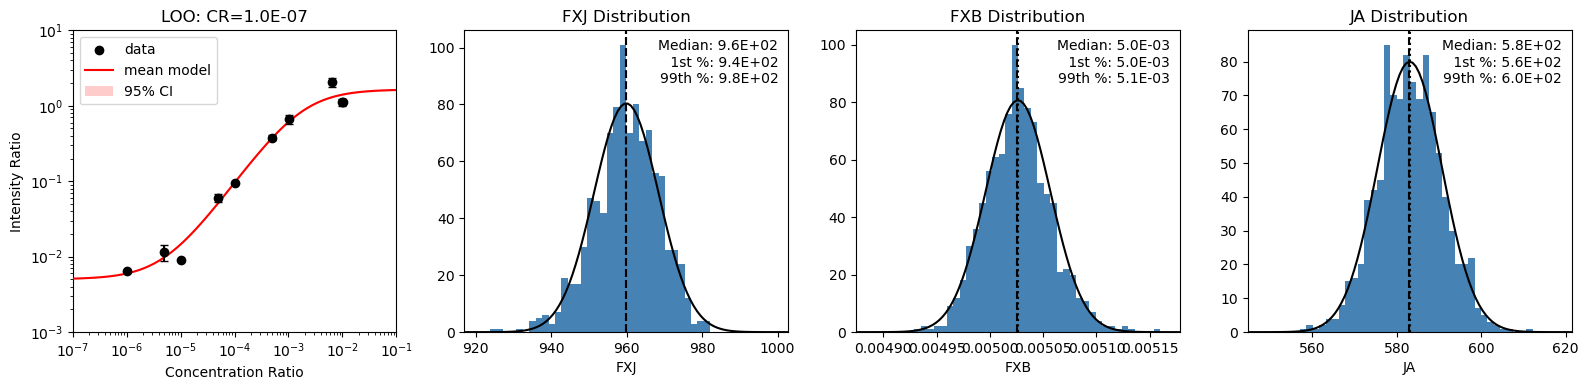


         end of plot_quantmodel_summary() function

CV results for t=0
    test CR: 1.0E-07
       FXJ: 9.60E2
       FXB: 5.03E-3
        JA: 5.83E2
    FXJ_JA: 1.65E0
    train RMSPE: 0.261
     test RMSPE: nan


2/11
training model on data minus point 1 (CR = 1.0E-06)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:136: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:136: RuntimeWarning: Mean of empty slice
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004621        0      inf     None     True     None     None
FXJ     959.8    1e-40      inf     None     True     None     None
JA      588.3        0      inf     None     True     None     None
log    

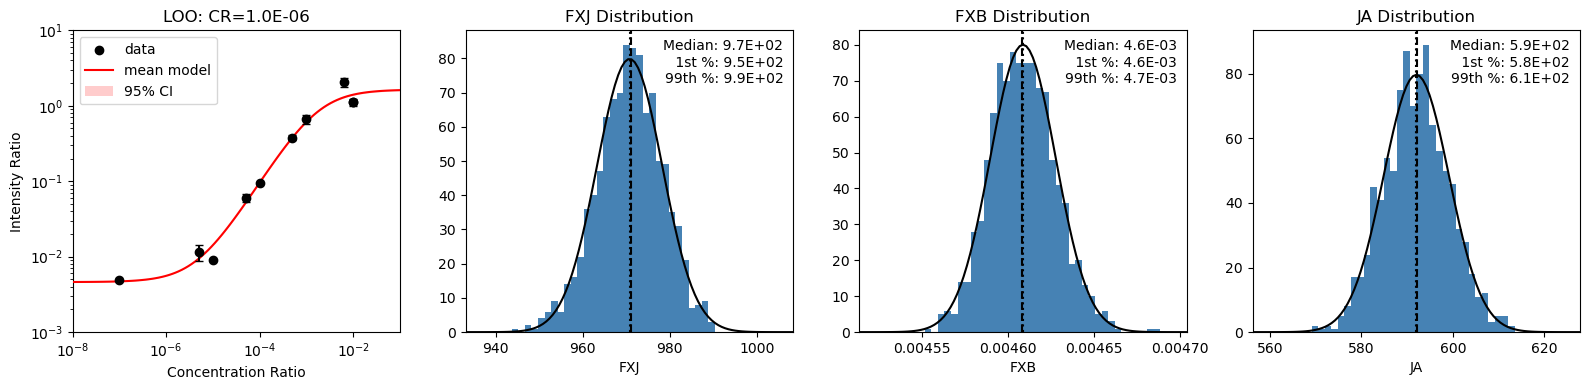


         end of plot_quantmodel_summary() function

CV results for t=1
    test CR: 1.0E-06
       FXJ: 9.71E2
       FXB: 4.61E-3
        JA: 5.92E2
    FXJ_JA: 1.64E0
    train RMSPE: 0.296
     test RMSPE: 0.291


3/11
training model on data minus point 2 (CR = 5.0E-06)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004705        0      inf     None     True     None     None
FXJ     954.2    1e-40      inf     None     True     None     None
JA        564        0      inf     None     True     None     None
log    

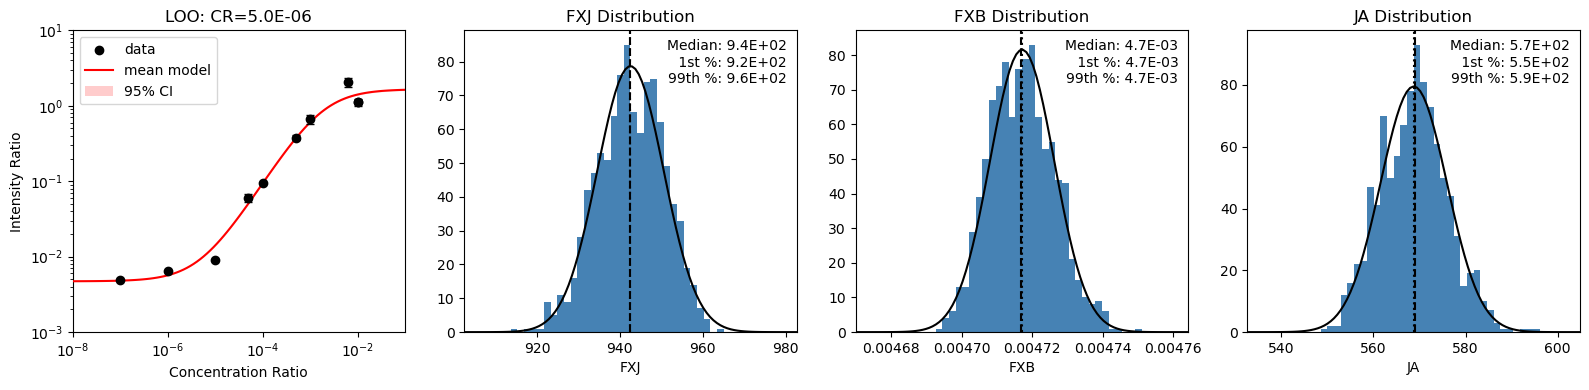


         end of plot_quantmodel_summary() function

CV results for t=2
    test CR: 5.0E-06
       FXJ: 9.43E2
       FXB: 4.72E-3
        JA: 5.69E2
    FXJ_JA: 1.66E0
    train RMSPE: 0.277
     test RMSPE: 0.272


4/11
training model on data minus point 3 (CR = 1.0E-05)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:136: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.005168        0      inf     None     True     None     None
FXJ      1086    1e-40      inf     None     True     None     None
JA      674.5        0      inf     None     True     None     None
log    

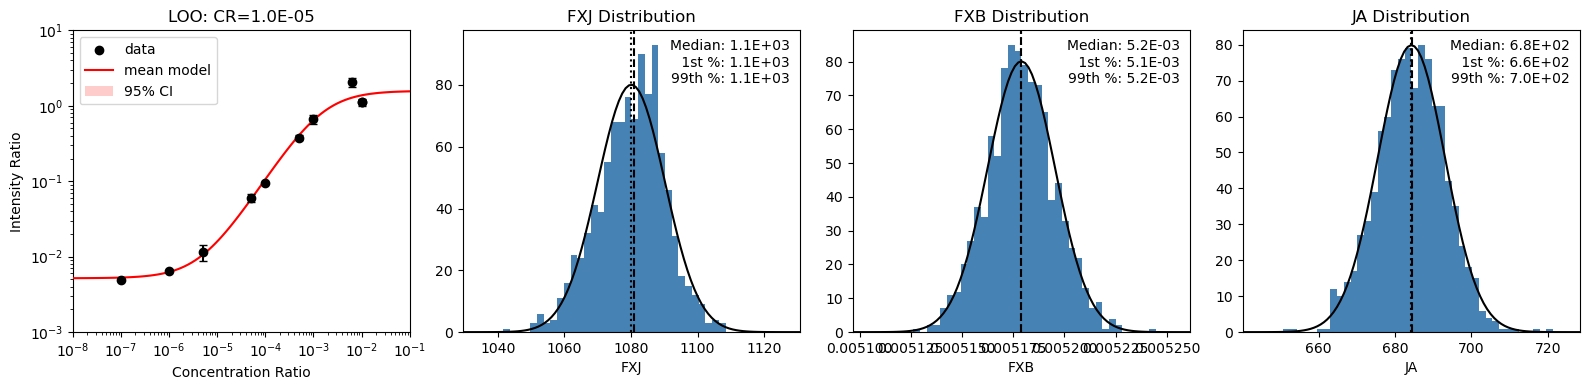


         end of plot_quantmodel_summary() function

CV results for t=3
    test CR: 1.0E-05
       FXJ: 1.08E3
       FXB: 5.18E-3
        JA: 6.84E2
    FXJ_JA: 1.58E0
    train RMSPE: 0.234
     test RMSPE: 0.457


5/11
training model on data minus point 4 (CR = 5.0E-05)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004994        0      inf     None     True     None     None
FXJ     898.5    1e-40      inf     None     True     None     None
JA      535.1        0      inf     None     True     None     None
log    

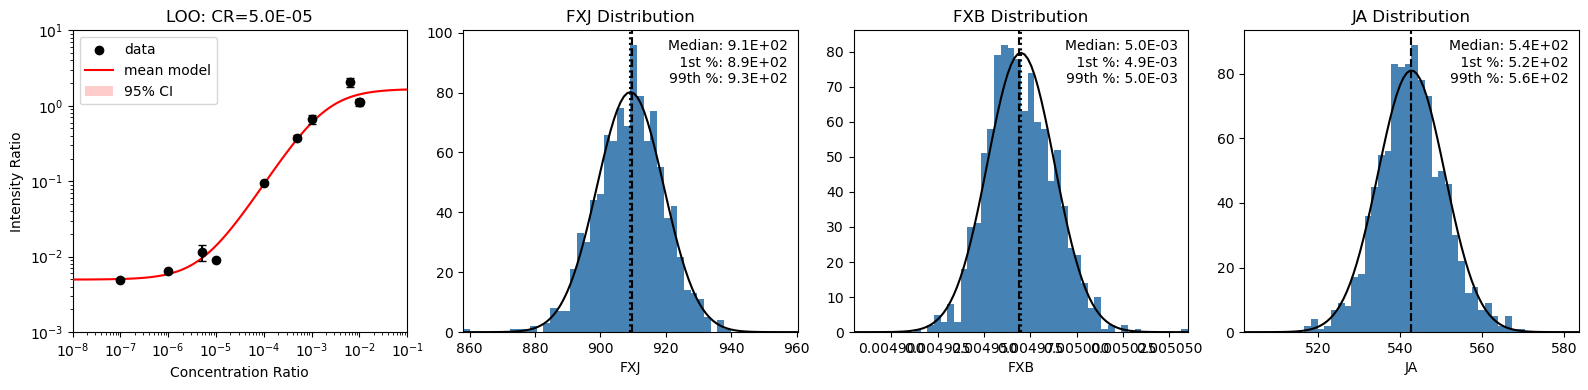


         end of plot_quantmodel_summary() function

CV results for t=4
    test CR: 5.0E-05
       FXJ: 9.10E2
       FXB: 4.97E-3
        JA: 5.43E2
    FXJ_JA: 1.68E0
    train RMSPE: 0.274
     test RMSPE: 0.112


6/11
training model on data minus point 5 (CR = 1.0E-04)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004908        0      inf     None     True     None     None
FXJ     970.5    1e-40      inf     None     True     None     None
JA      586.9        0      inf     None     True     None     None
log    

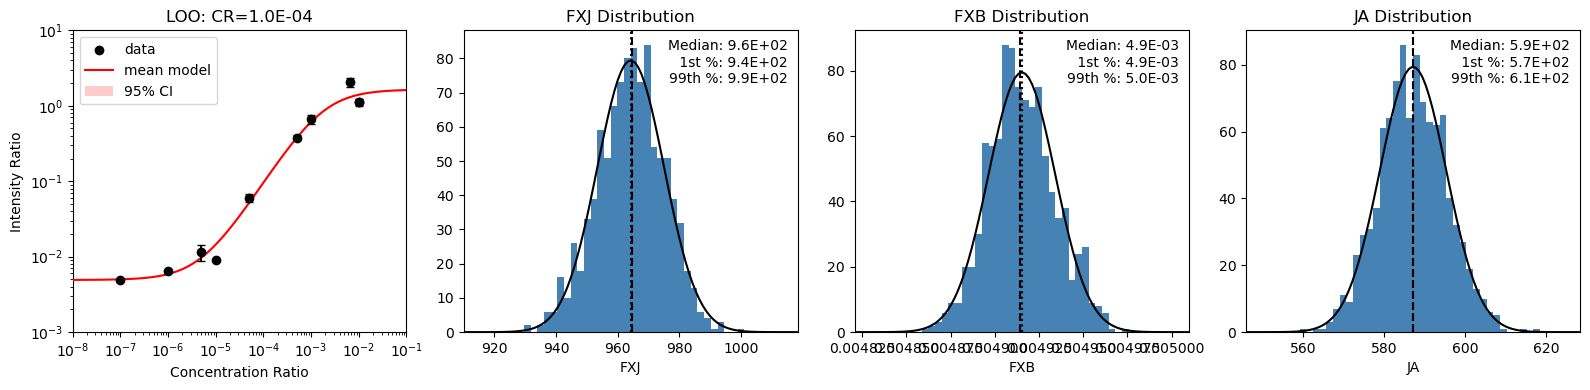


         end of plot_quantmodel_summary() function

CV results for t=5
    test CR: 1.0E-04
       FXJ: 9.65E2
       FXB: 4.91E-3
        JA: 5.87E2
    FXJ_JA: 1.64E0
    train RMSPE: 0.278
     test RMSPE: 0.000


7/11
training model on data minus point 6 (CR = 5.0E-04)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004911        0      inf     None     True     None     None
FXJ     977.4    1e-40      inf     None     True     None     None
JA      600.3        0      inf     None     True     None     None
log    

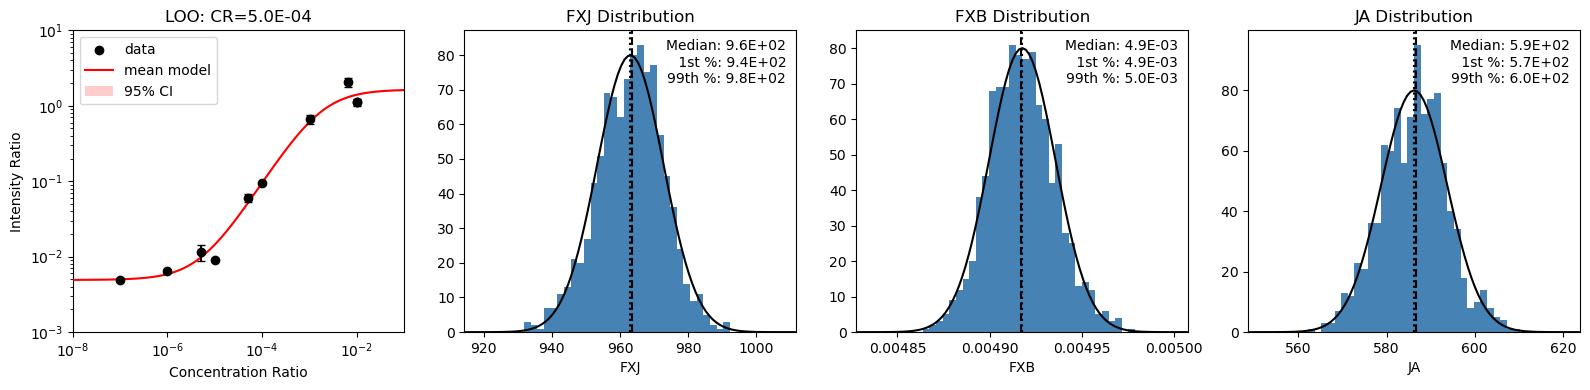


         end of plot_quantmodel_summary() function

CV results for t=6
    test CR: 5.0E-04
       FXJ: 9.64E2
       FXB: 4.92E-3
        JA: 5.87E2
    FXJ_JA: 1.64E0
    train RMSPE: 0.278
     test RMSPE: 0.048


8/11
training model on data minus point 7 (CR = 1.0E-03)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004942        0      inf     None     True     None     None
FXJ     948.9    1e-40      inf     None     True     None     None
JA      581.5        0      inf     None     True     None     None
log    

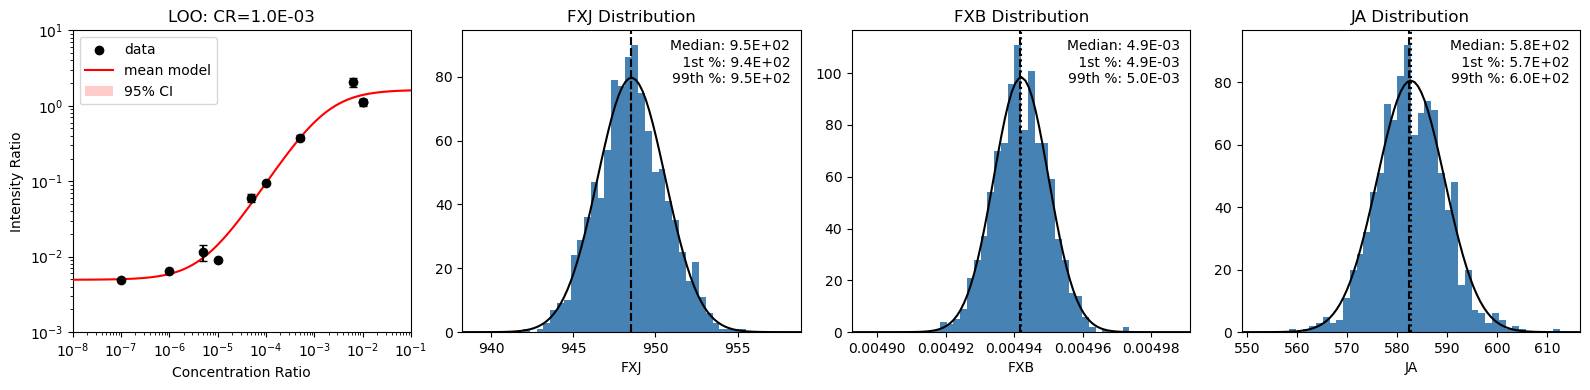


         end of plot_quantmodel_summary() function

CV results for t=7
    test CR: 1.0E-03
       FXJ: 9.49E2
       FXB: 4.94E-3
        JA: 5.82E2
    FXJ_JA: 1.63E0
    train RMSPE: 0.271
     test RMSPE: 0.122


9/11
training model on data minus point 8 (CR = 6.4E-03)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004876        0      inf     None     True     None     None
FXJ     988.4    1e-40      inf     None     True     None     None
JA      735.6        0      inf     None     True     None     None
log    

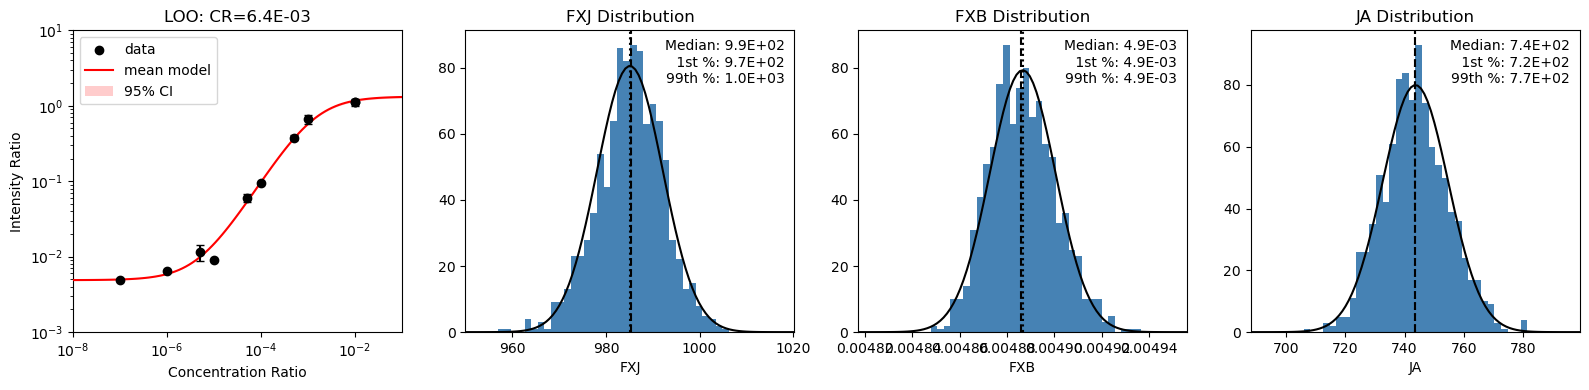


         end of plot_quantmodel_summary() function

CV results for t=8
    test CR: 6.4E-03
       FXJ: 9.85E2
       FXB: 4.89E-3
        JA: 7.43E2
    FXJ_JA: 1.33E0
    train RMSPE: 0.319
     test RMSPE: nan


10/11
training model on data minus point 9 (CR = 1.0E-02)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:136: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))
/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:136: RuntimeWarning: Mean of empty slice
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004941        0      inf     None     True     None     None
FXJ     948.3    1e-40      inf     None     True     None     None
JA      502.8        0      inf     None     True     None     None
log    

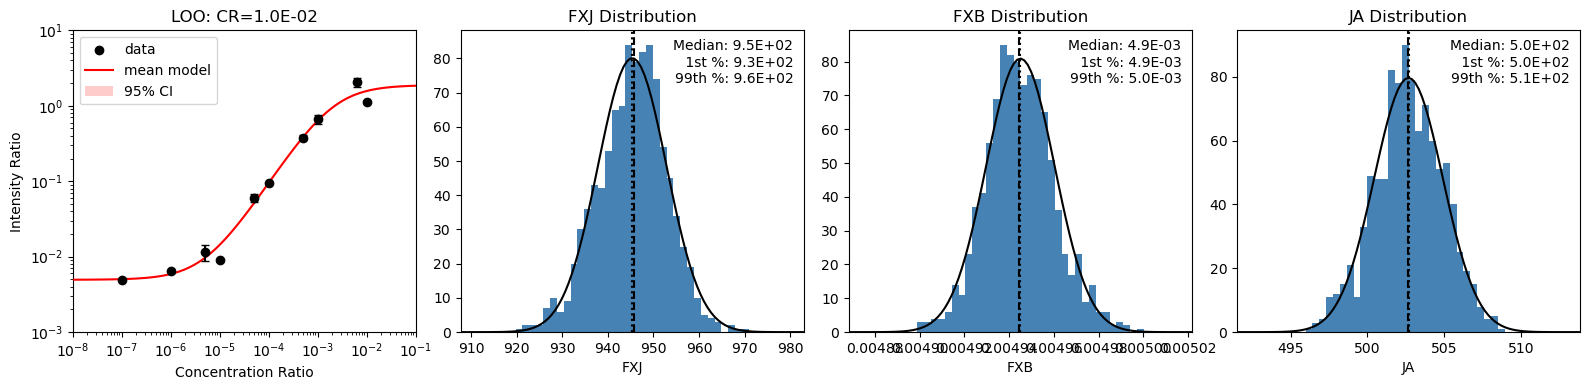


         end of plot_quantmodel_summary() function

CV results for t=9
    test CR: 1.0E-02
       FXJ: 9.46E2
       FXB: 4.94E-3
        JA: 5.03E2
    FXJ_JA: 1.88E0
    train RMSPE: 0.253
     test RMSPE: 0.544


11/11
training model on data minus point 10 (CR = 1.0E-02)
    training dataset: (10,) (10, 919)
     testing dataset: () (919,)


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,



     bootstrapping input data, N = 1000
          input data array: (10, 919)
         output data array: (10, 1000)

     proceeding with bootstrap modelling, N = 1000

 input data:
(10,) (10,)
     nans: 0
     infs: 0
     <=0:  0
     points trimmed: 0
 input parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB      0.01        0      inf     None     True     None     None
FXJ         1    1e-40      inf     None     True     None     None
JA       0.01        0      inf     None     True     None     None
log         1        0        1     None    False     None     None
None
 proceeding with fit
 fit status:  Optimization terminated successfully.
 fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FXB  0.004962        0      inf     None     True     None     None
FXJ     939.2    1e-40      inf     None     True     None     None
JA      494.2        0      inf     None     True     None     None
log    

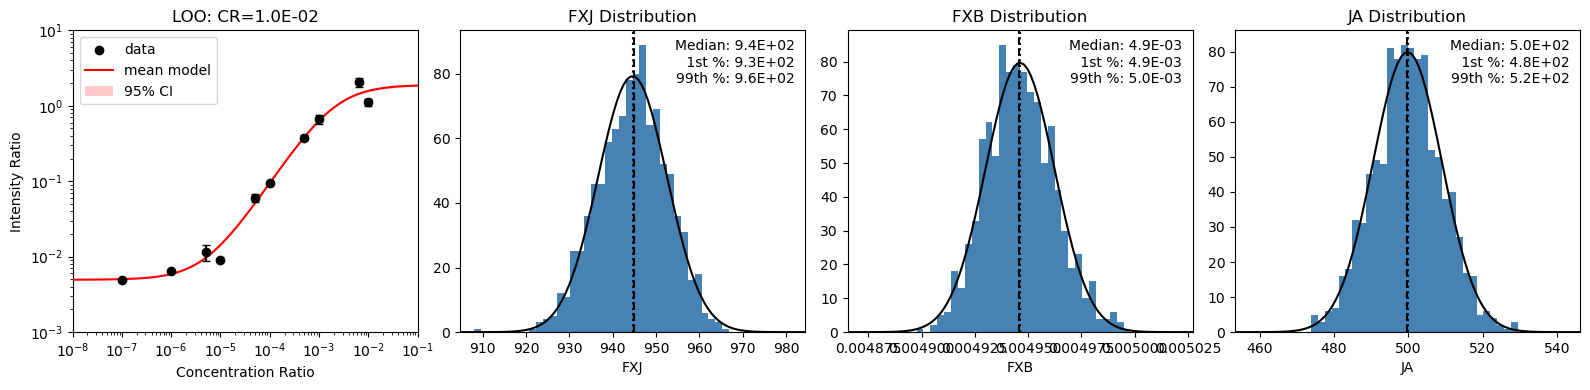


         end of plot_quantmodel_summary() function

CV results for t=10
    test CR: 1.0E-02
       FXJ: 9.45E2
       FXB: 4.95E-3
        JA: 5.00E2
    FXJ_JA: 1.89E0
    train RMSPE: 0.252
     test RMSPE: 0.549

DONE


/var/folders/54/d2hxt0352h1fr522wqnkkz7c0000gn/T/ipykernel_21103/1336315324.py:122: RuntimeWarning: invalid value encountered in log10
  RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [9]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = True

# define function to use when combining multiple intensity keys to get I1 or I2
combo_function = np.sum     # recommended: np.sum

# threshold for reporting issues (as fraction of datapoints)
report_threshold = 0.1

# show plots in viewer?
show_plot = False

# save plots to file?
save_plot = False

test_peaks = {
    'dATP/H2O': [1310, 3400],
    'dCTP/H2O': [1505, 3400],
    'dGTP/H2O': [1460, 3400],
    'dTTP/H2O': [1350, 3400],
    '9MA/CaSO4': [1600, 1004],
    '13DHN/CaSO4': [1600, 1004],
    'IOM/CaSO4': [1600, 1004],
}

tables['CV'] = pd.DataFrame(columns=['Test CR', 'Pred. CR', 'FXJ', 'FXB', 'JA', 'Train RMSPE', 'Test RMSPE'])

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL TRAINING...")
else:
    print("FITTING QUANTITATIVE MODEL TO TRAINING DATA...")
    
    print()
    print("doing leave-one-out cross-validation...")
    
    # ==================================================
    # get peak info
    v1_comp, v2_comp = Evaluation_Components
    v1_peak, v2_peak = test_peaks["%s/%s" % (v1_comp, v2_comp)]
    
    print()
    print("comparing %s/%s (%s/%s)" % (v1_peak, v2_peak, v1_comp, v2_comp))
    
    # ==================================================
    # get IR/CR data for peak pair
    
    CR = int_data["CR_%s/%s" % (v1_comp, v2_comp)]
    IR = int_data["IR_%s/%s" % (v1_peak, v2_peak)]
    
    print()
    print("CR,IR arrays:", np.shape(CR), np.shape(IR))
    
    test_indices = range(np.size(IR, axis=0))
    
    print()
    print("cross-validation steps:", len(test_indices))
    
    # proceed with LOO CV
    for ti in test_indices:
        # ==================================================
        # for each data point, remove it from dataset and train model
        title = "LOO: CR=%0.1E" % CR[ti]
        fig_dir = "%s%s/" % (Fig_dir, Mixture)
        
        print()
        print()
        print("%s/%s" % (ti+1, len(test_indices)))
        print("training model on data minus point %s (CR = %0.1E)" % (ti, CR[ti]))
        
        # ==================================================
        # split dataset into test and train
        
        # training
        CR_train = np.delete(CR, ti, axis=0)
        IR_train = np.delete(IR, ti, axis=0)
        
        print("    training dataset:", np.shape(CR_train), np.shape(IR_train))
        
        # testing
        CR_test = CR[ti]
        IR_test = IR[ti]
        
        print("     testing dataset:", np.shape(CR_test), np.shape(IR_test))
        
        text = parameter2string(param=CR_test, n=1, e=True)
        tables['CV'].loc[ti, "Test CR"] = text
            
        # ==================================================
        # train the model
        
        if Bootstrap == True:
            model = bootstrap_intensity_fit_script(CR_train, IR_train, title=title, tabs=1,
                                                        show_plot=True, save_plot=False, fig_dir=fig_dir, debug=debug)
        else:
            model = intensity_fit_script(CR, IR, debug=debug)
            
        print()
        print("CV results for t=%s" % ti)
        print("    test CR: %0.1E" % CR_test)
        
        # add fitted parameters to table
        for prop in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
            text = parameter2string(param=model[prop], n=2, e=True)
            tables['CV'].loc[ti, prop] = text
            print("    %6s: %s" % (prop, text))
        
        # ==================================================
        # test the model
        
        # get predictions for training data
        if IR_train.ndim > 1:
            IR_train_av = np.nanmean(IR_train, axis=1)
            IR_train_std = np.nanstd(IR_train, axis=1)
        else:
            IR_train_av = np.nanmean(IR_train)
            IR_train_std = np.nanstd(IR_train)
        CR_train_pred = predict_concentration(model, IR_train, percentiles=(16,84), return_all=True, clean_output=False)
        CR_train_pred_median = np.nanmedian(CR_train_pred, axis=-1)
        RMSPE = np.sqrt(np.nanmean(np.log10(CR_train_pred_median / CR_train)**2))
        
        tables['CV'].loc[ti, "Train RMSPE"] = "%0.3f" % RMSPE
        print("    train RMSPE: %0.3f" % RMSPE)
        
        # get predictions for testing data
        if IR_test.ndim > 1:
            IR_test_av = np.nanmean(IR_test, axis=1)
            IR_test_std = np.nanstd(IR_test, axis=1)
        else:
            IR_test_av = np.nanmean(IR_test)
            IR_test_std = np.nanstd(IR_test)
        CR_test_pred = predict_concentration(model, IR_test, percentiles=(16,84), return_all=True, clean_output=False)
        CR_test_pred_median = np.nanmedian(CR_test_pred, axis=-1)
        RMSPE = np.sqrt(np.nanmean(np.log10(CR_test_pred_median / CR_test)**2))
        
        text = percentiles2string(CR_test_pred, percentiles=(16,84), include_median=True, n=1, e=True)
        tables['CV'].loc[ti, "Pred. CR"] = text
        tables['CV'].loc[ti, "Test RMSPE"] = "%0.3f" % RMSPE
        print("     test RMSPE: %0.3f" % RMSPE)
        
        # ==================================================
        
    tables['CV'].to_csv("%s%s/CV_results.csv" % (Out_dir, Mixture))
    
    print()
    print("DONE")

## Do 2D correlation

In [10]:

skip = True

# print debug messages in viewer?
debug = True

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y'

# smooth data before measuring intensity?
smooth = True

threshold = 0.1


from mpl_toolkits.axes_grid1 import make_axes_locatable

if skip == True:
    print("skipping this section...")
else:
    print("DOING 2D CORRELATION...")
    
    # determine largest measurement array size
    lengths = [spec_data[ID].points for ID in Spec_IDs]
    print()
    print("samples in dataset:", len(Spec_IDs))
    print("measurements per sample:", lengths)
    print("    max:", max(lengths))
    
    # ==================================================
    # pick peak positions based on components
    
    int_data['peaks'] = np.concatenate([Intensity_Keys[comp]['Raw'] for comp in int_data['components']])
    int_data['peak_labels'] = np.concatenate([[comp]*len(Intensity_Keys[comp]['Raw']) for comp in int_data['components']])
    print()
    print("peaks to process:")
    for peak, label in zip(int_data['peaks'], int_data['peak_labels']):
        int_data["I_%d" % peak] = np.full((len(Spec_IDs), max(lengths)), np.nan, dtype=np.float64)
        print("%10s: %4d cm-1" % (label, peak), np.shape(int_data["I_%d" % peak]))
        
    x_temp = []
    y_temp = []
    for i1, ID in enumerate(Spec_IDs):
        # for each measurement
        
        # get spectrum
        x, y = get_plot_data(spec_data[ID], x_key, y_key, normalise=True)
        
        if smooth == True:
            for i in range(np.size(y, axis=1)):
                y[:,i] = smooth_spectrum(y[:,i], 5, 3)
        
        x_temp.append(x)
        y_temp.append(np.nanmedian(y, axis=-1))
        
    y_temp = np.asarray(y_temp)
    I1_check = y_temp[-1] > 0.1
    I2_check = y_temp[0] > 0.1
    print(np.shape(y_temp), np.shape(I1_check), np.shape(I2_check))
    print("I1 frequencies to analyse:", np.count_nonzero(I1_check))
    print("I1 frequencies to analyse:", np.count_nonzero(I2_check))
    print("models to fit:", np.count_nonzero(I2_check)*np.count_nonzero(I2_check))
    
    img_size = np.size(y_temp[0])
    img = np.zeros((img_size, img_size, 3))
    print(np.shape(img))
    
    x_temp = np.median(np.asarray(x_temp), axis=0)
    x_min = np.nanmin(x_temp)
    x_max = np.nanmax(x_temp)
    
    for i1 in np.arange(img_size)[I1_check]:
        img[i1,:,0] = 1.
    for i2 in np.arange(img_size)[I2_check]:
        img[:,i2,1] = 1.
    
    
    fig, ax = plt.subplots(figsize=(8,8))

    # handle img ax
    ax.imshow(img, extent=(x_min, x_max, x_max, x_min))

    # create new Axes on the right and on the top of the current Axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    # sort out x,y axis settings
    ax_x.set_xlim(x_min, x_max)
    ax_y.set_ylim(x_min, x_max)
    ax_x.xaxis.set_tick_params(labelbottom=False)
    ax_y.yaxis.set_tick_params(labelleft=False)
    ax_x.set_yticks([])
    ax_y.set_xticks([])
    
    # plot spectra
    ax_x.plot(x_temp, y_temp[0])
    ax_y.plot(y_temp[-1], x_temp)
    
    ax_x.axhline(threshold, c='k', linestyle=':')
    ax_y.axvline(threshold, c='k', linestyle=':')
    
    fig.show()
    
    print()
    print("end of Raw Mode measurement section!")

skipping this section...
